In [54]:
# adapted from: https://github.com/brandomr/document_cluster/blob/master/cluster_analysis_web.ipynb

In [55]:
import numpy as np
import pandas as pd
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
import os
import codecs
import unicodedata
from sklearn import feature_extraction
import mpld3
import matplotlib.pyplot as plt

### Load Data

In [56]:
df = pd.read_csv('abstracts.csv')

In [57]:
print (df.Title[0]) #first title

THRESH—Software for Tracking Rainfall Thresholds for Landslide and Debris-Flow Occurrence, User Manual


In [58]:
print (df.Text[0][0:250])

Precipitation thresholds are used in many areas to provide early warning of precipitation-induced landslides and debris flows, and the software distribution THRESH is designed for automated tracking of precipitation, including precipitation forecasts


### Stopwords, Stem, and Tokenize

In [59]:
# add appropriate words that will be ignored in the analysis
ADDITIONAL_STOPWORDS = ['version', '3', 'keyword', 'data', 'computer', 'program', 'input', 'file', 'output', '13', '4',
                        'upw', 'package', '5', 'u', 'x', '5m', 'grid', 'mississippi', 'document', 'report', 'provide', 
                        'area', 'many', 'used', 'including', 'designed', 'u', 'gi']
stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS


In [60]:
def basic_clean(text):
  """
  A simple function to clean up the data. All the words that
  are not designated as a stop word is then lemmatized after
  encoding and basic regex parsing are performed.
  """
  wnl = nltk.stem.WordNetLemmatizer()
  text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
  words = re.sub(r'[^\w\s]', '', text).split()
  filtered_words = []
  for word in words:
    if re.search('[a-zA-Z]', word):
        filtered_words.append(word)
  return [wnl.lemmatize(word) for word in filtered_words if word not in stopwords]

In [61]:
words = basic_clean(''.join(str(df['Text'].tolist())))

In [62]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [72]:
# tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [64]:
totalvocab_stemmed = []
totalvocab_tokenized = []

# ps = PorterStemmer()

for i in df.Text:
    tokens = [word for sent in sent_tokenize(i) for word in word_tokenize(sent)]
    filtered_tokens = []
    allwords_stemmed = tokenize_and_stem(i) #for each item in abstract texts, tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

## TD-IDF

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(df.Text) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

CPU times: user 201 ms, sys: 2.43 ms, total: 203 ms
Wall time: 202 ms
(40, 56)


In [67]:
terms = tfidf_vectorizer.get_feature_names()

In [68]:

from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

## Hierarchical Clustering

In [69]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances
# print(linkage_matrix)

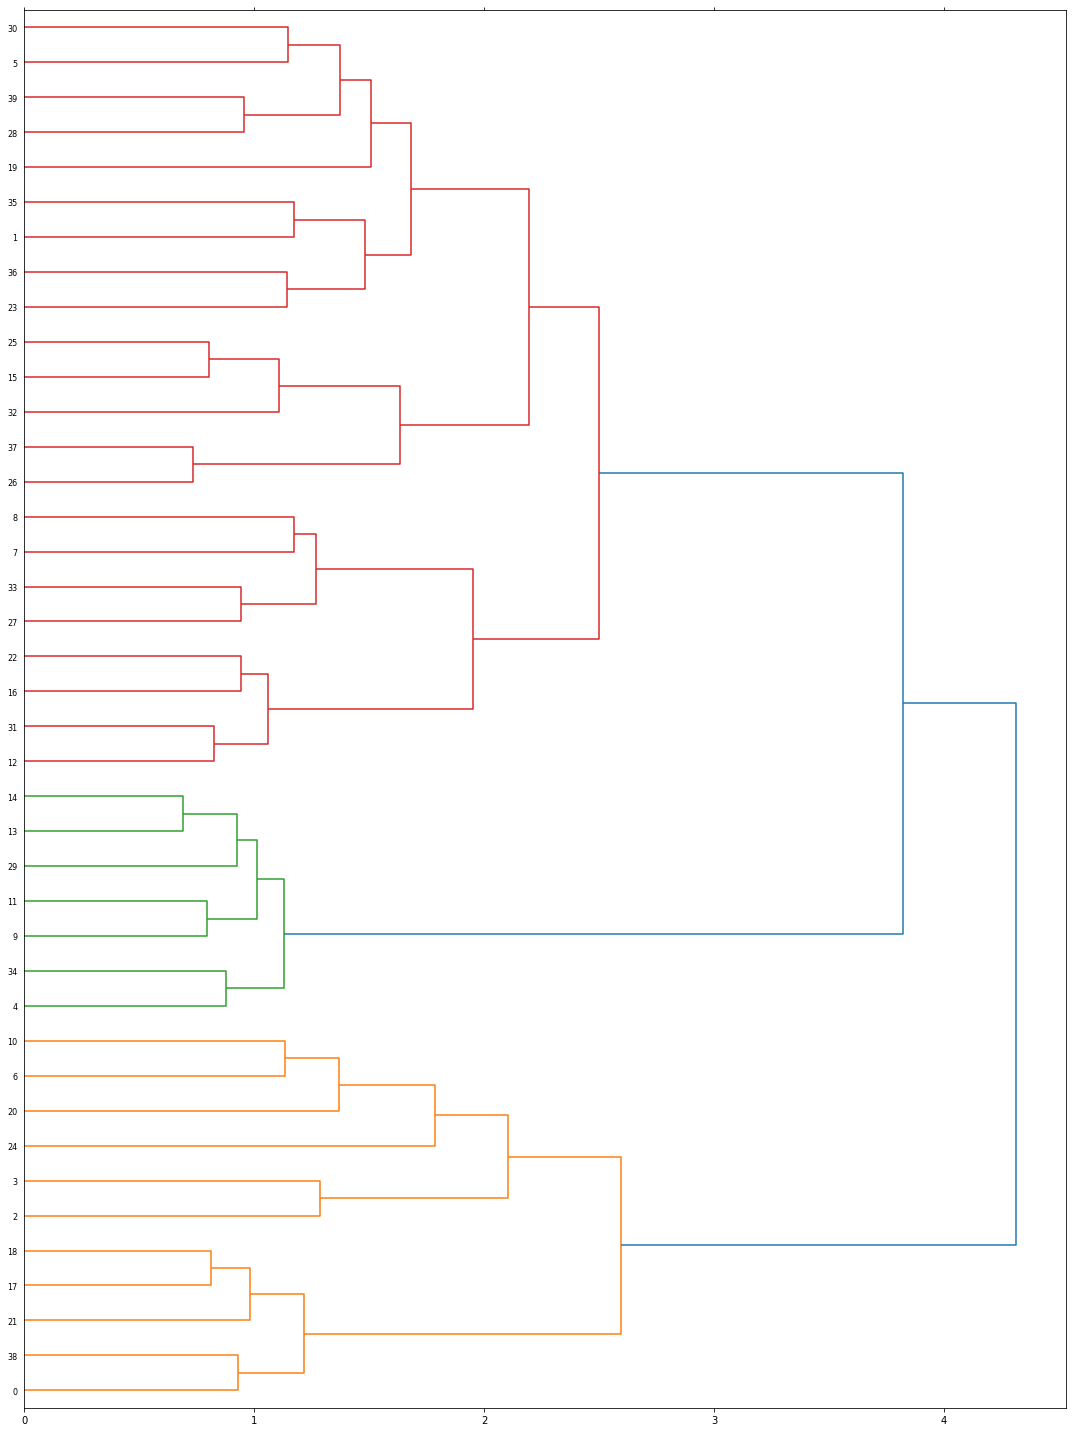

In [70]:
fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right");

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

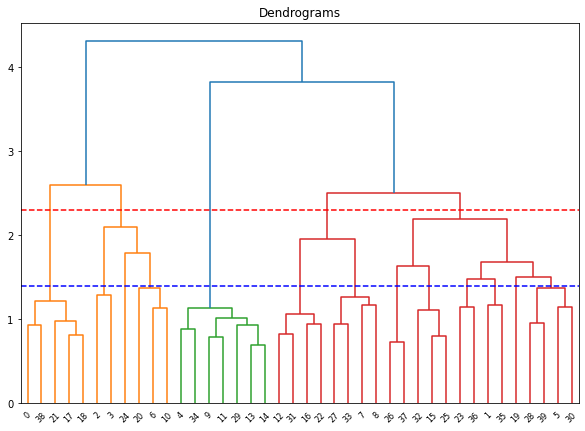

In [71]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(dist, method='ward'))
plt.axhline(y=2.3, color='r', linestyle='--')
plt.axhline(y=1.4, color='b', linestyle='--')